In [31]:
from processing_utils import DataPrepare
from studu_utils import load_best_global, save_best_global, plot_feature_importance


import polars as pl
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, GridSearchCV
from optuna.storages import RDBStorage
import matplotlib.pyplot as plt
import plotly
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from dash import Dash, html, dcc
import plotly.express as px
import optuna


In [32]:
df: pl.DataFrame = pl.read_parquet(r'C:\Users\310\Desktop\Progects_Py\data\microstructure_price_prediction_data\cross_section\df_from_2024-06-20_to_2024-07-10_with_delta_0-05-00.parquet')
target_var: str = "log_return"
cols_to_exclude = ['trade_time', 'is_buyer_maker', 'date',]
# File to store the best global results
BEST_GLOBAL_FILE = "best_global.json"

In [4]:
data = DataPrepare(df)

In [5]:
data.train_test_split(train_test_ratio=0.7, cols_to_exclude=None)
X_train, y_train, X_test, y_test, = data.X_y_split(target_var=target_var, target_encode=True)

Train test ratio is 0.7
Train len for DOGEUSDT is 4031
Test len for DOGEUSDT is 1729
Train len for AVAXUSDT is 4031
Test len for AVAXUSDT is 1729


In [6]:
# Initialize best global results
best_global = load_best_global(BEST_GLOBAL_FILE)

In [7]:
def objective(trial, X_train, y_train, features):
    # Store the features in trial user attributes
    trial.set_user_attr("features", features)

    # Hyperparameter space
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.5)

    # Define the RandomForestRegressor with trial parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        min_impurity_decrease=min_impurity_decrease,
        random_state=42,
        n_jobs=-1,
    )

    # Use K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)

    # Return the mean MSE score
    return np.mean(mse_scores)


In [22]:
def optimize_with_dataset(X_train, y_train, study_name=None):
    global best_global

    features = list(X_train.columns)

    if study_name:
        pass
    if features == best_global["features"]:
        study_name = best_global["study_name"]
    else:
        study_name = datetime.now().strftime("study_%Y-%m-%d_%H-%M-%S")
    

    # Create a new study
    study = optuna.create_study(
        study_name=study_name,
        storage="sqlite:///optuna_study.db",
        direction="minimize",
        load_if_exists=True
    )

    # Run optimization
    study.optimize(lambda trial: objective(trial, X_train, y_train, features), n_trials=2)

    # Update the global best result if the current study has a better score
    if study.best_value < best_global["best_value"]:
        best_global.update(
            {
                "study_name": study_name,
                "best_value": study.best_value,
                "best_params": study.best_params,
                "features": features,
            }
        )
        # Save the updated best global results to disk
        save_best_global(best_global, BEST_GLOBAL_FILE)

    # Print the best result for this study
    print(f"Study: {study_name}")
    print(f"Best Value: {study.best_value}")
    print(f"Best Params: {study.best_params}")

    # Return the study for further analysis if needed
    return study


To open dashbourd run this:

optuna-dashboard sqlite:///optuna_study.db

And listen to:

http://localhost:8080/

In [9]:
!optuna-dashboard sqlite:///optuna_study.db


^C


In [23]:
study = optimize_with_dataset(X_train, y_train)

[I 2024-12-13 12:30:11,442] Using an existing study with name 'study_2024-12-13_11-47-41' instead of creating a new one.
[I 2024-12-13 12:30:16,387] Trial 32 finished with value: 4.669084468048335e-06 and parameters: {'n_estimators': 313, 'max_depth': 27, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.3897299690154515, 'min_impurity_decrease': 0.09785931117238196}. Best is trial 31 with value: 4.669084082943781e-06.
[I 2024-12-13 12:30:19,927] Trial 33 finished with value: 4.6690977317431895e-06 and parameters: {'n_estimators': 247, 'max_depth': 28, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.3400170619598119, 'min_impurity_decrease': 0.12280899581619742}. Best is trial 31 with value: 4.669084082943781e-06.


Study: study_2024-12-13_11-47-41
Best Value: 4.669084082943781e-06
Best Params: {'n_estimators': 426, 'max_depth': 28, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.38609780987612236, 'min_impurity_decrease': 0.10248211956118797}


In [26]:
# Test
rf_model = RandomForestRegressor(**study.best_params, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.4f}")


Mean Squared Error on the test set: 0.0000


In [28]:
rf_model.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

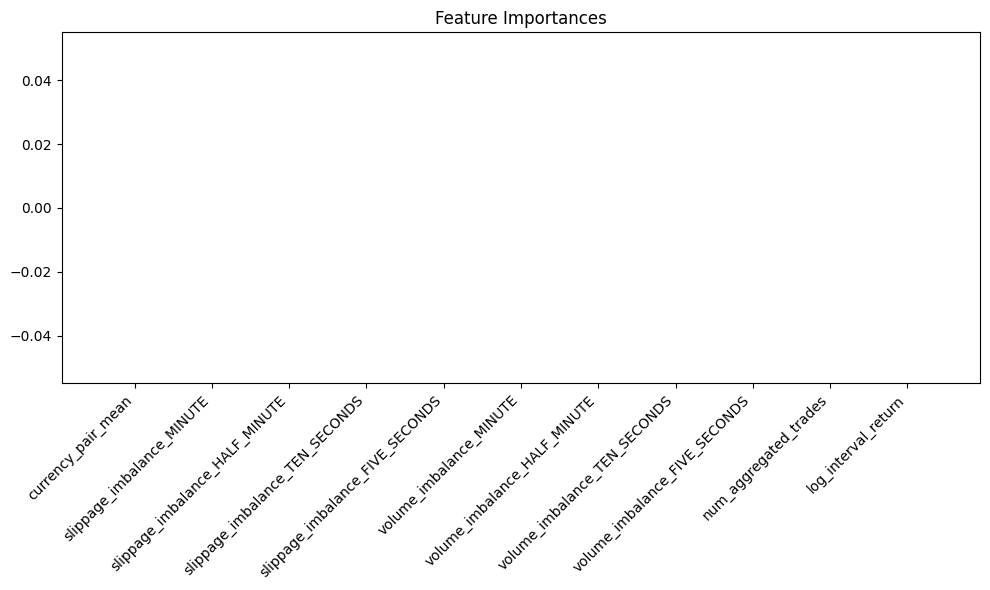

In [33]:
plot_feature_importance(rf_model, X_train.columns)

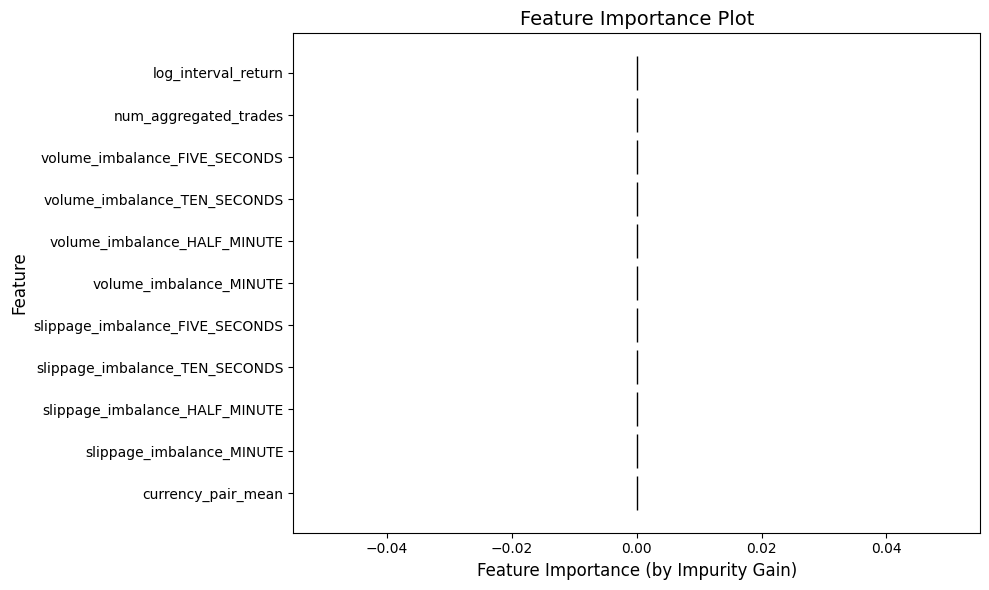

In [27]:
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame for easy manipulation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], edgecolor='k')
plt.xlabel('Feature Importance (by Impurity Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance Plot', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.tight_layout()
plt.show()